In [15]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import cv2
from skimage.metrics import structural_similarity as ssim
import random
from scipy.signal import find_peaks



Processed image shape: (512, 512)


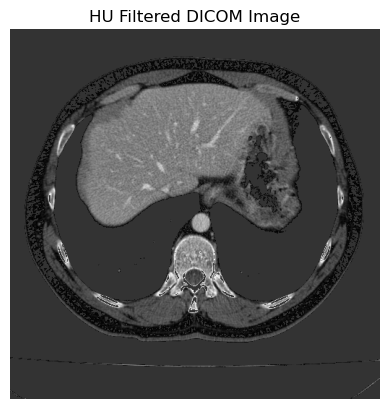

In [14]:
def process_single_dicom_image(dicom_file):
    """
    Load and preprocess a single DICOM image.

    Parameters:
    - dicom_file (str): The path to the DICOM file.

    Returns:
    - hu_filtered_image (np.ndarray): The normalized Hounsfield Units (HU) filtered image.
    """
    try:
        
        dicom_data = pydicom.dcmread(dicom_file)
        image_data = dicom_data.pixel_array

        
        intercept = dicom_data.RescaleIntercept if 'RescaleIntercept' in dicom_data else 0
        slope = dicom_data.RescaleSlope if 'RescaleSlope' in dicom_data else 1
        hu_image = image_data * slope + intercept

        
        hu_filtered_image = np.where((hu_image >= -100) & (hu_image <= 400), hu_image, 0)

        
        hu_filtered_image = hu_filtered_image - np.min(hu_filtered_image)
        hu_filtered_image = (hu_filtered_image / np.max(hu_filtered_image)) * 255
        hu_filtered_image = hu_filtered_image.astype(np.float32) / 255.0

        return hu_filtered_image

    except Exception as e:
        print(f"Error processing DICOM file {dicom_file}: {e}")
        return None


dicom_file_path = '/home/23m1522/Wnet/new_tr/i0022,0000b.dcm'  # Specify the path to your DICOM file
hu_image = process_single_dicom_image(dicom_file_path)

if hu_image is not None:
    print("Processed image shape:", hu_image.shape)
    plt.imshow(hu_image, cmap='gray')
    plt.title("HU Filtered DICOM Image")
    plt.axis('off')
    plt.show()

In [8]:
class DicomDataset(Dataset):
    def __init__(self, dicom_dir):
        self.dicom_dir = dicom_dir
        self.images = self.load_dicom_images(dicom_dir)

    def load_dicom_images(self, dicom_dir):
        images = []
        valid_files = 0

        for root, _, files in os.walk(dicom_dir):
            for file in files:
                if file.endswith('.dcm'):
                    dicom_file = os.path.join(root, file)
                    try:
                        dicom_data = pydicom.dcmread(dicom_file)
                        image_data = dicom_data.pixel_array

                        
                        intercept = dicom_data.RescaleIntercept if 'RescaleIntercept' in dicom_data else 0
                        slope = dicom_data.RescaleSlope if 'RescaleSlope' in dicom_data else 1
                        hu_image = image_data * slope + intercept

                        
                        hu_filtered_image = np.where((hu_image >= -100) & (hu_image <= 400), hu_image, 0)

                        
                        hu_filtered_image = hu_filtered_image - np.min(hu_filtered_image)
                        hu_filtered_image = (hu_filtered_image / np.max(hu_filtered_image)) * 255
                        hu_filtered_image = hu_filtered_image.astype(np.float32) / 255.0

                        images.append(hu_filtered_image)
                        valid_files += 1
                    except Exception as e:
                        print(f"Error loading DICOM file {dicom_file}: {e}")

        print(f"Loaded {valid_files} valid DICOM images from {dicom_dir}")
        return np.array(images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  
        return image

 
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.sigmoid(self.psi(psi))
        return x * psi

# Basic 2D U-Net Architecture
class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2D, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.decoder1 = self.upconv(512, 256)
        self.decoder1_conv = self.conv_block(512, 256)
        
        self.decoder2 = self.upconv(256, 128)
        self.decoder2_conv = self.conv_block(256, 128)
        
        self.decoder3 = self.upconv(128, 64)
        self.decoder3_conv = self.conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        self.att1 = AttentionGate(256, 256, 128)
        self.att2 = AttentionGate(128, 128, 64)
        self.att3 = AttentionGate(64, 64, 32)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        dec1 = self.decoder1(enc4)
        att1 = self.att1(dec1, enc3)
        dec1 = torch.cat((att1, enc3), dim=1)
        dec1 = self.decoder1_conv(dec1)

        dec2 = self.decoder2(dec1)
        att2 = self.att2(dec2, enc2)
        dec2 = torch.cat((att2, enc2), dim=1)
        dec2 = self.decoder2_conv(dec2)

        dec3 = self.decoder3(dec2)
        att3 = self.att3(dec3, enc1)
        dec3 = torch.cat((att3, enc1), dim=1)
        dec3 = self.decoder3_conv(dec3)
        
        return self.final_conv(dec3)


class WNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(WNet, self).__init__()
        self.unet1 = UNet2D(in_channels, out_channels)
        self.fc_conv = nn.Conv2d(out_channels, num_classes, kernel_size=1, stride=1)
        self.unet2 = UNet2D(num_classes, in_channels)

    def forward(self, x):
        seg_output = self.unet1(x)
        fc_output = self.fc_conv(seg_output)
        softmax_output = F.softmax(fc_output, dim=1)
        reconstruction_output = self.unet2(softmax_output)
        return seg_output, softmax_output, reconstruction_output


def soft_ncuts_loss(output, weight_matrix):
    clusters = output.shape[1]
    P = torch.softmax(output, dim=1)
    cut_value = 0
    assoc_value = 0

    for k in range(clusters):
        P_k = P[:, k, :, :]
        
        
        cut_value += torch.sum(weight_matrix * P_k * (1 - P_k))
        
        
        assoc_value += torch.sum(weight_matrix * P_k)

    
    return (clusters - (cut_value / assoc_value))


def ssim_loss(img1, img2):
    img1_np = img1.squeeze(1).cpu().detach().numpy()
    img2_np = img2.squeeze(1).cpu().detach().numpy()
    batch_ssim_loss = 0

    for i in range(img1_np.shape[0]):
        win_size = min(7, min(img1_np[i].shape))
        ssim_val = ssim(img1_np[i], img2_np[i], data_range=1, win_size=win_size)
        batch_ssim_loss += (1 - ssim_val)

    return batch_ssim_loss / img1_np.shape[0]

def compute_maximum_std(segmented_output, num_classes):
    max_stds = []

    for i in range(num_classes):
        cluster_output = segmented_output[:, i, :, :].detach().cpu().numpy().flatten()

        # Calculate standard deviation of the pixel values
        std_dev = np.std(cluster_output)
        max_stds.append(std_dev)

    return max_stds


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)


def train_wnet_with_max_std(model, data_loader, optimizer, num_clusters, epochs):
    model.train()
    device = 'cpu'
    model = model.to(device)

    
    std_devs = np.zeros((num_clusters, epochs))

    for epoch in range(epochs):
        epoch_loss = 0
        for original_images in data_loader:
            original_images = original_images.to(device)
            optimizer.zero_grad()

            
            outputs = model(original_images)

            if len(outputs) == 3:
                seg_output, softmax_output, recon_output = outputs
            elif len(outputs) == 2:
                seg_output, recon_output = outputs
            else:
                raise ValueError("Unexpected number of outputs from the model.")

            
            weight_matrix = torch.ones_like(seg_output)
            loss_ncuts = soft_ncuts_loss(seg_output, weight_matrix)
            loss_ssim = ssim_loss(original_images, recon_output)
            loss = loss_ncuts + loss_ssim

            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            
            seg_output_np = softmax_output.detach().cpu().numpy()
            for k in range(num_clusters):
                cluster_pixels = seg_output_np[:, k, :, :].flatten()  
                std_dev = np.std(cluster_pixels)
                std_devs[k, epoch] += std_dev / len(data_loader)

        print(f"Epoch [{epoch + 1}/{epochs}], N-Cuts Loss: {loss_ncuts.item()}, SSIM Loss: {loss_ssim.item()}, Total Loss: {epoch_loss / len(data_loader)}")

    average_stds = std_devs.mean(axis=1)  

    
    max_std_cluster = np.argmax(average_stds)
    print(f"Cluster with maximum average standard deviation: {max_std_cluster}, Standard Deviation: {average_stds[max_std_cluster]}")
    
    return max_std_cluster
                



device = 'cpu'
dicom_dir = '/home/23m1522/Wnet/new_tr'
dataset = DicomDataset(dicom_dir)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
set_seed(42)
wnet = WNet(in_channels=1, out_channels=64, num_classes=10).to(device)

optimizer = torch.optim.Adam(wnet.parameters(), lr=0.001)
selected_cluster = train_wnet_with_max_std(wnet, data_loader, optimizer, num_clusters=10, epochs=11)



Loaded 11 valid DICOM images from /home/23m1522/Wnet/new_tr
Epoch [1/11], N-Cuts Loss: 0.6301597356796265, SSIM Loss: 0.6603576669038592, Total Loss: 1.384416710246693
Epoch [2/11], N-Cuts Loss: 0.6301572322845459, SSIM Loss: 0.6822667447138717, Total Loss: 1.2682715329256924
Epoch [3/11], N-Cuts Loss: 0.6301565766334534, SSIM Loss: 0.6957673999772573, Total Loss: 1.309115095572038
Epoch [4/11], N-Cuts Loss: 0.6301564574241638, SSIM Loss: 0.6914457138140291, Total Loss: 1.2824188037352129
Epoch [5/11], N-Cuts Loss: 0.6301563382148743, SSIM Loss: 0.6891603095402213, Total Loss: 1.2949628721583972
Epoch [6/11], N-Cuts Loss: 0.6301563382148743, SSIM Loss: 0.7019390178523313, Total Loss: 1.292139931158586
Epoch [7/11], N-Cuts Loss: 0.6301563382148743, SSIM Loss: 0.7177037784104174, Total Loss: 1.3151841705495662
Epoch [8/11], N-Cuts Loss: 0.6301562786102295, SSIM Loss: 0.7158879036294746, Total Loss: 1.3175652352246372
Epoch [9/11], N-Cuts Loss: 0.6301562786102295, SSIM Loss: 0.71784959115

In [11]:
model =wnet  
model_path = '/home/23m1522/Wnet/wnet_model.pth'
model.load_state_dict(torch.load(model_path, map_location= "cpu"))
model.to( "cpu")
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


/tmp/ipykernel_1061072/995961726.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location= "cpu"))


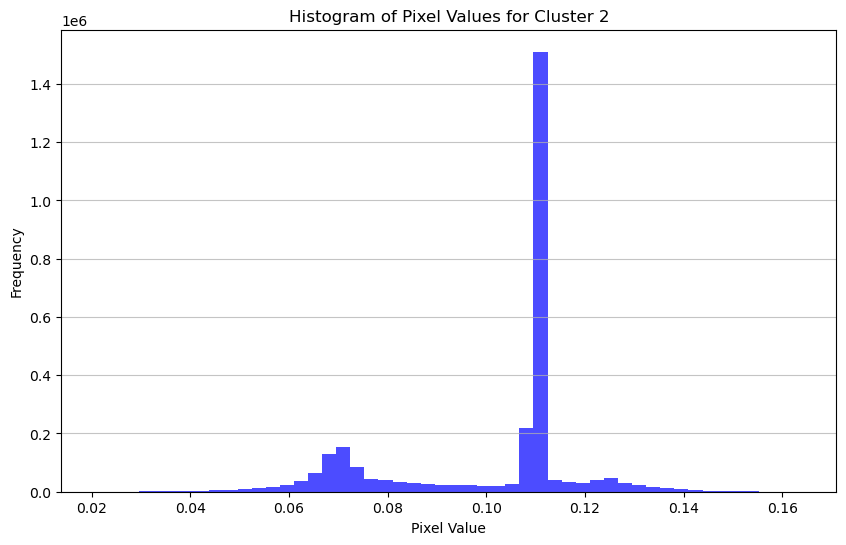

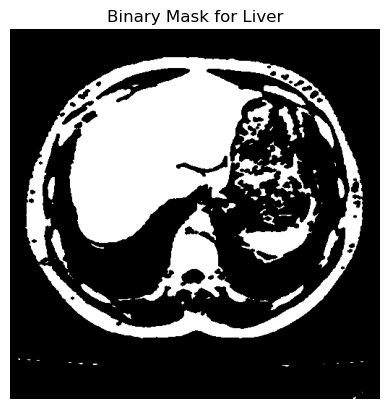

In [12]:
def find_first_minimum_after_peak(hist, start_index):
    """Find the first minimum in the histogram after the specified index."""
    for i in range(start_index + 1, len(hist) - 1):
        if hist[i] < hist[i - 1] and hist[i] < hist[i + 1]:
            return i
    return None  

def visualize_and_segment_liver(data_loader, model, selected_cluster):
    model.eval()
    device = 'cpu'  
    softmax_outputs = []

    with torch.no_grad():
        for original_images in data_loader:
            original_images = original_images.to(device)
            _, softmax_output, _ = model(original_images)
            softmax_outputs.extend(softmax_output.cpu().numpy())

    softmax_outputs = np.array(softmax_outputs)

    
    pixel_values = []
    for i in range(len(softmax_outputs)):
        cluster_output = softmax_outputs[i, selected_cluster, :, :]
        pixel_values.append(cluster_output[cluster_output > 0])  

    pixel_values = np.concatenate(pixel_values)

    
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of Pixel Values for Cluster {selected_cluster}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    
    hist, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 1))
    peaks, _ = find_peaks(hist)
    sorted_peaks = sorted(zip(peaks, peaks), key=lambda x: x[1], reverse=True)
    peak_heights = hist[peaks]
    sorted_peaks = sorted(zip(peaks, peak_heights), key=lambda x: x[1], reverse=True)

    larger_peak_idx, larger_peak_height = sorted_peaks[0]
    smaller_peak_idx, smaller_peak_height = sorted_peaks[1]
    larger_peak_idx, larger_peak_height = sorted_peaks[0]
    smaller_peak_idx, smaller_peak_height = sorted_peaks[1]

    
    sorted_peaks = sorted(zip(peaks, peak_heights), key=lambda x: x[1])

    print(f"Larger Peak: {bin_edges[larger_peak_idx]} at height {larger_peak_height}")
    print(f"Smaller Peak: {bin_edges[smaller_peak_idx]} at height {smaller_peak_height}")
    

    
    if smaller_peak_idx < larger_peak_idx:
        # Case 1: Smaller peak appears before the larger peak
        first_minimum_index = find_first_minimum_after_peak(hist, smaller_peak_idx)
        if first_minimum_index is not None:
            first_minimum_value = bin_edges[first_minimum_index]
            print(f"First Minimum after smaller peak (Threshold for <): {first_minimum_value}")
            binary_mask = (cluster_output < first_minimum_value).astype(np.uint8)
        else:
            raise ValueError("No minimum found after the smaller peak.")

    else:
        # Case 2: Smaller peak appears after the larger peak
        # Find the first minimum before the smaller peak
        first_minimum_index = None
        for i in range(smaller_peak_idx - 1, -1, -1):
            if hist[i] < hist[i - 1] and hist[i] < hist[i + 1]:
                first_minimum_index = i
                break
        
        if first_minimum_index is not None:
            first_minimum_value = bin_edges[first_minimum_index]
            print(f"First Minimum before smaller peak (Threshold for >): {first_minimum_value}")
            binary_mask = (cluster_output > first_minimum_value).astype(np.uint8)
        else:
            raise ValueError("No minimum found before the smaller peak.")


masks = visualize_and_segment_liver(data_loader, wnet, selected_cluster)

# Display the first mask as a test
plt.imshow(masks[0], cmap='gray')
plt.title('Binary Mask for Liver')
plt.axis('off')
plt.show()

In [13]:
def find_centroid(binary_mask):
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  

    
    largest_contour = max(contours, key=cv2.contourArea)

    
    moments = cv2.moments(largest_contour)

    if moments['m00'] == 0:
        return None  

    
    centroid_x = int(moments['m10'] / moments['m00'])
    centroid_y = int(moments['m01'] / moments['m00'])

    return (centroid_x, centroid_y)


binary_mask = masks[0]  
centroid = find_centroid(binary_mask)

if centroid:
    print(f'Centroid of the liver region: {centroid}')
else:
    print('No contours found in the binary mask.')

Centroid of the liver region: (215, 189)


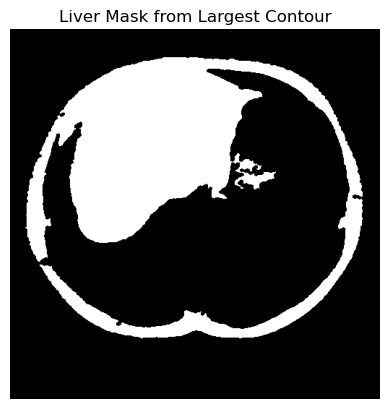

In [14]:
def create_mask_from_largest_contour(binary_mask):
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea) if contours else None
    mask = np.zeros_like(binary_mask)

    if largest_contour is not None:
        
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    return mask

liver_mask = create_mask_from_largest_contour(binary_mask)

# Display the resulting liver mask
plt.imshow(liver_mask, cmap='gray')
plt.title('Liver Mask from Largest Contour')
plt.axis('off')
plt.show()

In [15]:
centroid_contour = find_centroid(liver_mask)
print(centroid_contour)

(215, 189)


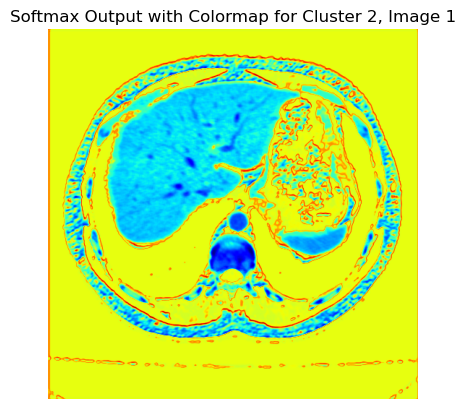

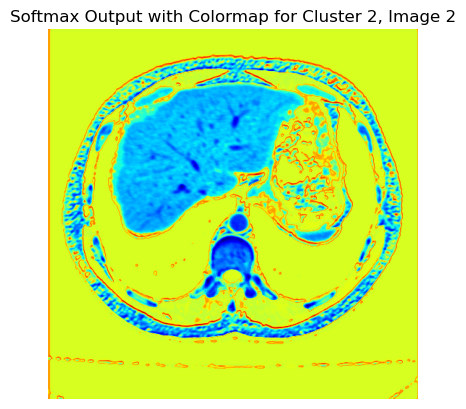

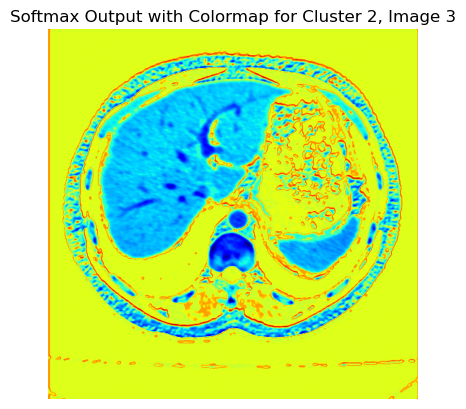

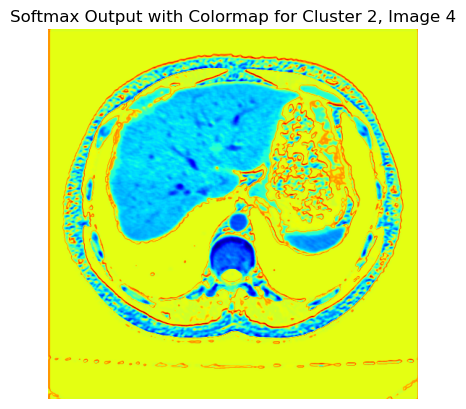

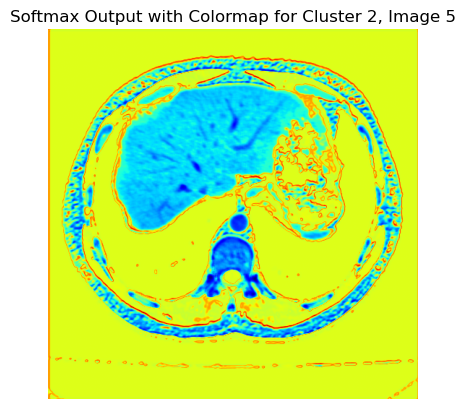

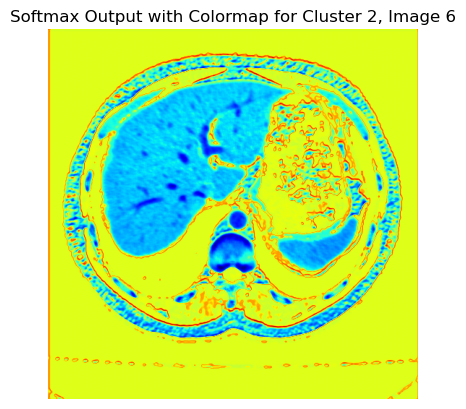

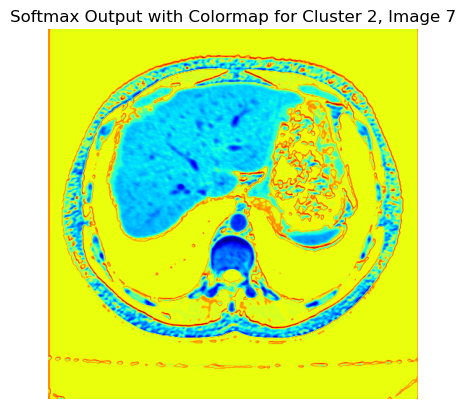

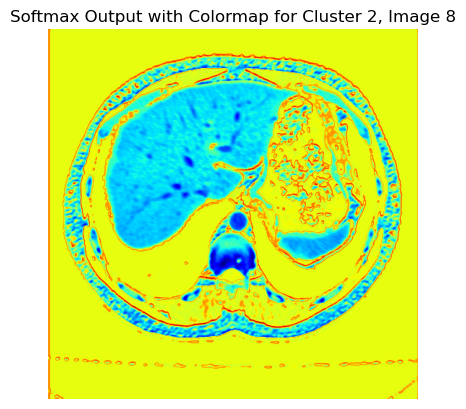

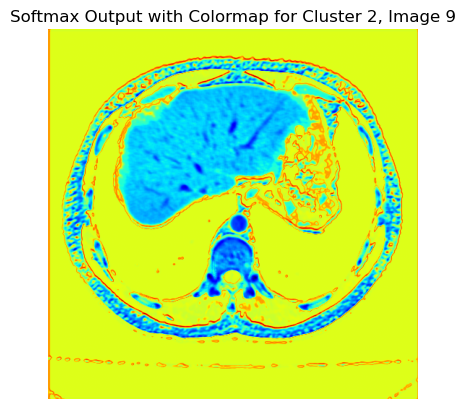

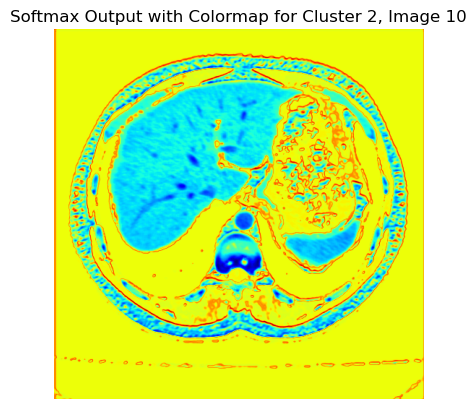

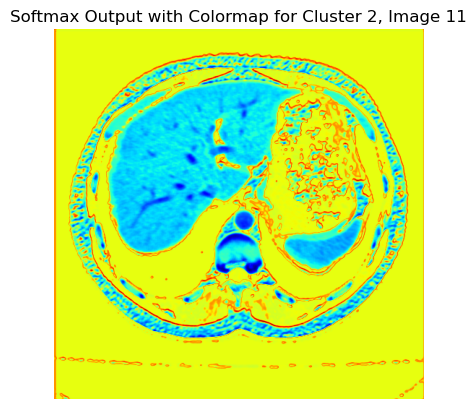

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

selected_cluster = 2  
softmax_outputs = []

# Disable gradient calculations
with torch.no_grad():
    for original_images in data_loader:
        original_images = original_images.to(device)
        
        # Get the model output
        _, softmax_output, _ = model(original_images)
        
        # Move output to CPU and convert to numpy
        softmax_outputs.extend(softmax_output.cpu().numpy())

# Convert list to numpy array
softmax_outputs = np.array(softmax_outputs)

# Collect pixel values for the specific selected cluster
pixel_values = []
for i in range(len(softmax_outputs)):
    # Extract only the selected cluster output
    cluster_output = softmax_outputs[i, selected_cluster, :, :]
    pixel_values.append(cluster_output)

# Convert to a numpy array
pixel_values = np.array(pixel_values)

# Apply colormap to the selected cluster output
for i, cluster_map in enumerate(pixel_values):
    # Normalize the cluster output for better visualization
    norm_cluster_map = (cluster_map - cluster_map.min()) / (cluster_map.max() - cluster_map.min())
    
    # Apply colormap (e.g., 'viridis', 'plasma', 'hot', etc.)
    cmap_applied = cm.jet(norm_cluster_map)

    # Display the result
    plt.figure()
    plt.imshow(cmap_applied)
    plt.title(f"Softmax Output with Colormap for Cluster {selected_cluster}, Image {i+1}")
    plt.axis('off')
    plt.show()

/home/23m1522/.local/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


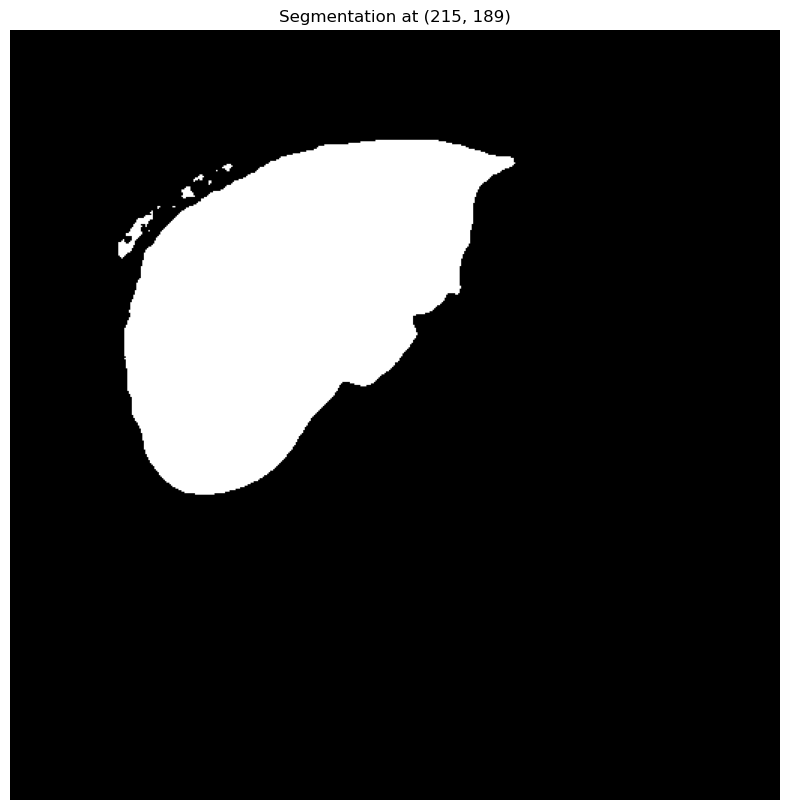

In [17]:
def segment_liver_with_sam(cmap_applied, coords=None):
    # Load SAM model
    sam_checkpoint = "/home/23m1522/Wnet/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
    model_type = "vit_h"  # Model type
    device = "cpu"  # Change to "cuda" if using a GPU
    
    # Initialize the SAM model
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device)
    
    # Ensure cmap_applied is in RGB format by removing alpha channel if present
    if cmap_applied.shape[-1] == 4:  # If RGBA, remove alpha
        mask_image = cmap_applied[..., :3]
    else:
        mask_image = cmap_applied  # Already RGB

    # Generate masks for the whole image
    mask_generator = SamAutomaticMaskGenerator(sam)
    all_masks = mask_generator.generate(mask_image)  # Generate all possible masks

    if coords is not None and all_masks:
        segmented_masks = []

        # Check each coordinate
        for coord in coords:
            coord_x, coord_y = coord
            found_mask = False

            # Iterate through the generated masks to find one that includes the point
            for mask in all_masks:
                if mask['segmentation'][coord_y, coord_x]:  # Check if the mask includes the coordinate
                    segmented_masks.append(mask['segmentation'])
                    found_mask = True
                    break

            if not found_mask:
                print(f"No mask found for coordinates: {coord}")

        # Visualize the segmented masks
        if segmented_masks:
            plt.figure(figsize=(10, 10))
            for i, mask in enumerate(segmented_masks):
                plt.subplot(1, len(segmented_masks), i + 1)
                plt.imshow(mask, cmap='gray')
                plt.title(f"Segmentation at {coords[i]}")
                plt.axis('off')
            plt.show()
        else:
            print("No valid masks found for the provided coordinates.")
    else:
        print("Coordinates not provided or no masks generated.")


segment_liver_with_sam(cmap_applied, coords=[centroid])  # Example coordinates

In [20]:
cmap_applied.shape

(512, 512, 4)